<div align="center"> 

# **"R Code to Python Conversion: K-Means Clustering"**

</div>

### **What does the R code even do?**
*To be able to translate something we should first understand what it's doing in the first place, we copy and pasted the R code into chatgpt with the prompt "Explain what this R code is doing" so we could get a better understand of what we're dealing with.*

### **ChatGPT Response Summarized w/ Translation:**

**Data Preparation**:

- It first loads a variety of libraries (like dplyr, lubridate, data.table, factoextra, etc.) to handle data manipulation, date conversion, plotting, and clustering.
    The dataset is copied into a variable named “tidy” and its columns are renamed to more meaningful labels (e.g. “pnr” for patient number, “eksd” for event date, “ATC” for drug classification, etc.).

- The date column “eksd” is converted into a proper date format using the mdy() function from the lubridate package.


In [5]:
import pandas as pd
import matplotlib as plt

data = pd.read_csv("../Dataset/ExamplePats.csv")

data.head()


,pnr,eksd,perday,ATC,dur_original
0,1,2033-04-26,4,medA,50
1,1,2033-07-04,4,medB,30
2,1,2033-08-03,4,medB,30
3,1,2033-08-17,4,medB,30
4,1,2033-10-13,4,medB,30


- In this cell we load in the csv into our data variable and we call the data.head() function to see if we've successfully imported our data.
  
- Since the dataset has been properly formatted before hand, we wouldn't to change any formatting regarding the columns of the data and the format of the dates.

### **Function "SEE": Analyzing Prescription Intervals for a Specific Drug**

*The function See(arg1) takes a drug code (e.g., "medA" or "medB") and performs the following steps:*

**Subsetting the Data**:
- It filters the dataset to include only records where the “ATC” column matches the given drug code.

**Calculating Time Intervals**:
- For each patient (grouped by “pnr”), the function computes the time difference (event interval) between consecutive prescription dates (“eksd”). It does this by arranging the events chronologically and using a lag function.

**Random Sampling**:
- For each patient, one prescription interval is randomly selected. This helps to standardize the sample for further analysis.

**ECDF Plotting**:
- An empirical cumulative distribution function (ECDF) is generated for the event intervals. The function then creates two plots: one for the lower 80% of the ECDF (to focus on the bulk of the data, likely reducing the influence of outliers) and one for the full ECDF. Both are saved as PNG files.

**Histogram and Density Plot**:
- A histogram of the number of events per patient is plotted. Then, the logarithm of the event intervals is taken and its density is computed and plotted. This log transformation can help normalize skewed interval data.

**Clustering Analysis**:
- The code performs silhouette analysis to determine the optimal number of clusters for the log-transformed intervals. Using k-means clustering, it then groups the intervals into clusters. For each cluster, summary statistics (minimum, maximum, median) are computed.
The function then assigns a cluster (and the corresponding median duration) to each event based on whether its interval falls within the range of that cluster.

**Merging Results**:
- Finally, the original data (for the specified drug) is merged with the cluster results so that each record now includes an assigned “Median” (typical duration) and “Cluster” identifier.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Helper function to compute ECDF
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

def see(drug_code, data):
    # 1. Subset the data by the given drug code
    drug_data = data[data['ATC'] == drug_code].copy()
    
    # 2. Convert the prescription date column to datetime and sort by patient and date
    drug_data['eksd'] = pd.to_datetime(drug_data['eksd'])
    drug_data = drug_data.sort_values(by=['pnr', 'eksd'])
    
    # Calculate previous prescription date for each patient using groupby and shift
    drug_data['prev_eksd'] = drug_data.groupby('pnr')['eksd'].shift(1)
    
    # Remove the first prescription for each patient (no previous date)
    drug_data = drug_data.dropna(subset=['prev_eksd']).copy()
    
    # 3. Calculate the time interval (in days) between consecutive prescriptions
    drug_data['event_interval'] = (drug_data['eksd'] - drug_data['prev_eksd']).dt.days
    
    # 4. For each patient, randomly select one prescription interval
    sampled = drug_data.groupby('pnr').apply(lambda x: x.sample(1)).reset_index(drop=True)
    
    # 5. ECDF Plotting
    # Full ECDF
    x_ecdf, y_ecdf = ecdf(sampled['event_interval'])
    plt.figure()
    plt.plot(x_ecdf, y_ecdf, marker='.', linestyle='none')
    plt.xlabel('Event Interval (days)')
    plt.ylabel('ECDF')
    plt.title(f'Full ECDF for {drug_code}')
    plt.savefig(f'ECDF_{drug_code}_full.png')
    plt.close()
    
    # ECDF for lower 80% of intervals
    cutoff = np.percentile(sampled['event_interval'], 80)
    mask = sampled['event_interval'] <= cutoff
    x_ecdf_80, y_ecdf_80 = ecdf(sampled.loc[mask, 'event_interval'])
    plt.figure()
    plt.plot(x_ecdf_80, y_ecdf_80, marker='.', linestyle='none')
    plt.xlabel('Event Interval (days)')
    plt.ylabel('ECDF')
    plt.title(f'ECDF up to 80th percentile for {drug_code}')
    plt.savefig(f'ECDF_{drug_code}_80.png')
    plt.close()
    
    # 6. Histogram of the number of events per patient
    events_per_patient = drug_data.groupby('pnr').size()
    plt.figure()
    events_per_patient.plot(kind='bar')
    plt.xlabel('Patient (pnr)')
    plt.ylabel('Number of events')
    plt.title(f'Prescription Events per Patient for {drug_code}')
    plt.savefig(f'Histogram_{drug_code}.png')
    plt.close()
    
    # Density plot of log-transformed event intervals (using only intervals <= cutoff)
    filtered_intervals = sampled[sampled['event_interval'] <= cutoff]['event_interval']
    log_intervals = np.log(filtered_intervals)
    plt.figure()
    sns.kdeplot(log_intervals, shade=True)
    plt.xlabel('log(Event Interval)')
    plt.title(f'Density Plot of log(Event Interval) for {drug_code}')
    plt.savefig(f'Density_{drug_code}.png')
    plt.close()
    
   # 7. Clustering Analysis on log-transformed intervals (for filtered data only)
    cutoff = np.percentile(sampled['event_interval'], 80)
    mask_filtered = sampled['event_interval'] <= cutoff
    filtered_sampled = sampled[mask_filtered].copy()
    # Compute log-transformed intervals for the filtered rows
    X = np.log(filtered_sampled['event_interval'].values).reshape(-1, 1)
    
    best_k = 2
    best_score = -1
    scores = {}
    # Try cluster numbers from 2 to 5
    for k in range(2, 6):
        kmeans_temp = KMeans(n_clusters=k, random_state=1234).fit(X)
        score = silhouette_score(X, kmeans_temp.labels_)
        scores[k] = score
        if score > best_score:
            best_score = score
            best_k = k
    print("Silhouette scores for different k:", scores)
    print("Optimal number of clusters:", best_k)
    
    # Apply k-means clustering with the optimal number of clusters on the filtered data
    kmeans = KMeans(n_clusters=best_k, random_state=1234).fit(X)
    filtered_sampled['cluster'] = kmeans.labels_
    
    # Compute summary statistics for each cluster (on the original event_interval)
    cluster_stats = filtered_sampled.groupby('cluster')['event_interval'].agg(['min', 'max', 'median']).reset_index()
    
    # Merge the cluster labels from filtered_sampled back into the full sampled DataFrame.
    # For patients that did not meet the filtering criterion, the cluster will be NaN.
    sampled = pd.merge(sampled, filtered_sampled[['pnr', 'cluster']], on='pnr', how='left')
    
    # Merge the cluster summary statistics (specifically the 'median') back into sampled.
    sampled = pd.merge(sampled, cluster_stats[['cluster', 'median']], on='cluster', how='left')
    
    # 8. Merge the cluster info back into the full drug_data on patient ID (pnr)
    merged = pd.merge(drug_data, sampled[['pnr', 'median', 'cluster']], on='pnr', how='left')
    
    # If any patient did not receive a cluster assignment, fill with overall median
    overall_median = sampled['median'].median()
    merged['median'] = merged['median'].fillna(overall_median)
    merged['cluster'] = merged['cluster'].fillna(-1)
    
    return merged

# Example usage:
# Assuming you have your DataFrame loaded as "tidy"
# result_medA = see("medA", tidy)
# result_medB = see("medB", tidy)


### **Function ‘see_assumption’: Visualizing Sequential Prescription Patterns**

*The function see_assumption(arg1) takes a dataset (for example, the output from See()) and:*

- Groups the data by patient and assigns a sequential number (p_number) to each prescription event.

- Calculates the duration between consecutive prescriptions (using the previously computed “prev_eksd” and “eksd” values).

- Creates a boxplot of these durations against the prescription sequence number. A horizontal dashed line is overlaid to show the overall median duration across patients.

- This plot helps in visualizing whether the time between prescriptions changes as patients accumulate more events.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def see_assumption(data):
    """
    Visualize sequential prescription patterns.

    Parameters:
      data (DataFrame): A DataFrame that includes at least the columns 'pnr', 'eksd', and 'prev_eksd'.
                        It is assumed that 'eksd' (and 'prev_eksd', if present) are datetime strings or already in datetime format.

    Returns:
      The matplotlib figure object of the generated boxplot.
    """
    # Make a copy of the data
    df = data.copy()
    
    # Ensure that 'eksd' is in datetime format
    df['eksd'] = pd.to_datetime(df['eksd'])
    
    # If 'prev_eksd' exists, ensure it is in datetime format
    if 'prev_eksd' in df.columns:
        df['prev_eksd'] = pd.to_datetime(df['prev_eksd'])
    
    # Group by patient ('pnr') and assign a sequential prescription number
    df['p_number'] = df.groupby('pnr').cumcount() + 1

    # We can only compute a duration if a patient has at least two prescriptions.
    # Filter the data to include only events with a prescription number of 2 or more.
    df_filtered = df[df['p_number'] >= 2].copy()
    
    # Calculate the duration (in days) between consecutive prescriptions.
    # If the 'Duration' column doesn't exist, create it.
    if 'Duration' not in df_filtered.columns:
        df_filtered['Duration'] = (df_filtered['eksd'] - df_filtered['prev_eksd']).dt.days
    
    # Create a boxplot with prescription sequence number on the x-axis and duration on the y-axis.
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='Duration', data=df_filtered)
    
    # Calculate the overall median duration across patients.
    overall_median = df_filtered['Duration'].median()
    
    # Overlay a horizontal dashed line at the median duration.
    plt.axhline(overall_median, linestyle='--', color='red', 
                label=f'Overall Median: {overall_median} days')
    plt.legend()
    
    # Add labels and title
    plt.xlabel('Prescription Sequence Number')
    plt.ylabel('Duration between Prescriptions (days)')
    plt.title('Boxplot of Prescription Durations by Sequence Number')
    
    # Save the plot to a PNG file (it will be stored in the current working directory)
    plt.savefig('see_assumption_boxplot.png')
    
    # Display the plot
    plt.show()
    
    # Optionally, return the current figure
    return plt.gcf()

# Example usage:
# If you have already run your 'see' function and stored the result in 'result_medA':
# fig = see_assumption(result_medA)


### **Execution and Output:**

- The script applies the See() function for two different drug codes: "medA" and "medB", creating two separate subsets of the data with their corresponding analyses.

- Then, it calls see_assumption() on both of these subsets to generate boxplots that depict the distribution of prescription intervals by order (i.e., 2nd prescription, 3rd prescription, etc.).

- All plots (ECDFs, histogram, density plot, silhouette plot, and the boxplots) are saved as PNG files.

C:\Users\Fabiola\AppData\Local\Temp\ipykernel_1220\3077008878.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = drug_data.groupby('pnr').apply(lambda x: x.sample(1)).reset_index(drop=True)
C:\Users\Fabiola\AppData\Local\Temp\ipykernel_1220\3077008878.py:71: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(log_intervals, shade=True)


Silhouette scores for different k: {2: np.float64(0.6038782968321937), 3: np.float64(0.5745522301000158), 4: np.float64(0.6223252492681752), 5: np.float64(0.620712217771254)}
Optimal number of clusters: 4


C:\Users\Fabiola\AppData\Local\Temp\ipykernel_1220\3077008878.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = drug_data.groupby('pnr').apply(lambda x: x.sample(1)).reset_index(drop=True)
C:\Users\Fabiola\AppData\Local\Temp\ipykernel_1220\3077008878.py:71: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(log_intervals, shade=True)


Silhouette scores for different k: {2: np.float64(0.5789765285622455), 3: np.float64(0.5365784608648496), 4: np.float64(0.5610445947257782), 5: np.float64(0.5634811155429972)}
Optimal number of clusters: 2


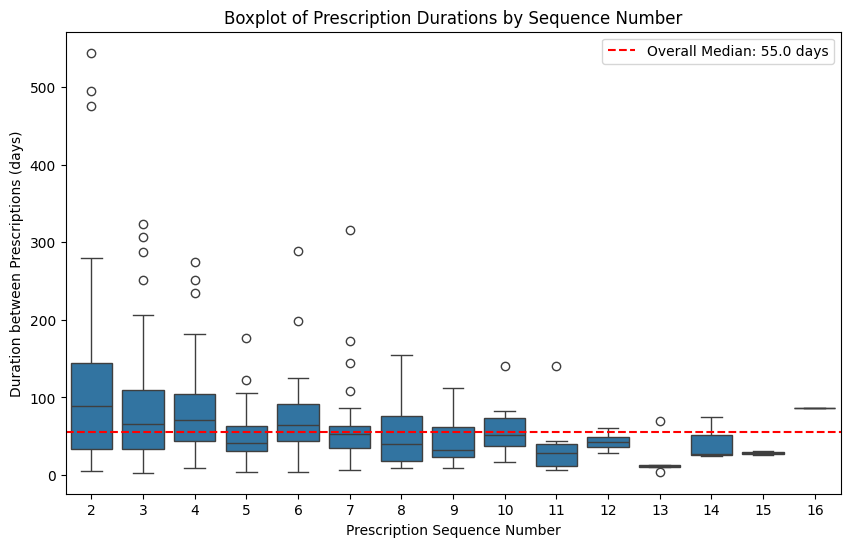

<Figure size 640x480 with 0 Axes>

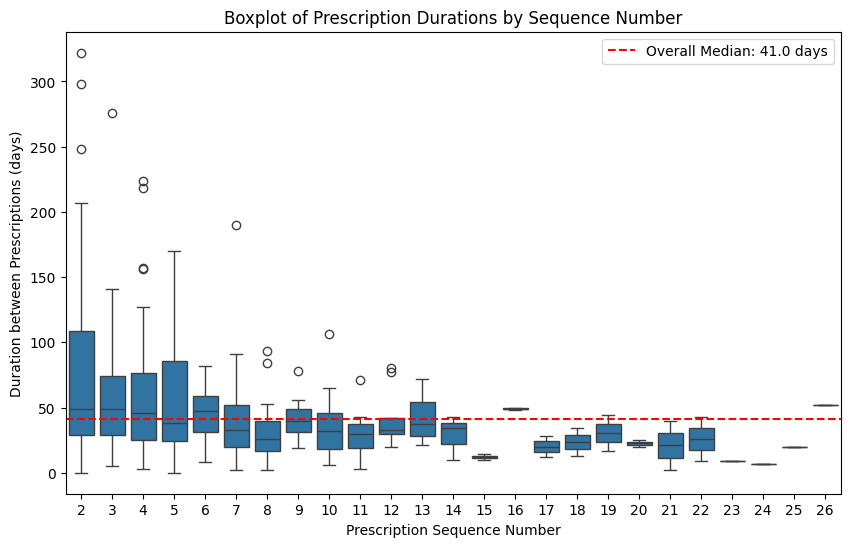

Analysis complete. All plots have been saved as PNG files in the current working directory.


<Figure size 640x480 with 0 Axes>

In [8]:
# Execute the analysis for drug code "medA"
result_medA = see("medA", data)
# Execute the analysis for drug code "medB"
result_medB = see("medB", data)

# Generate boxplots of prescription intervals by sequence using see_assumption()
fig_medA = see_assumption(result_medA)
fig_medB = see_assumption(result_medB)

print("Analysis complete. All plots have been saved as PNG files in the current working directory.")


<div align="center"> 

---

### **K-Means: Advantages and Disadvantages**

</div>

<div align="justify"> 

##### **Advantages:**

K-Means is a simple and computationally efficient clustering algorithm, making it **suitable for large datasets**. Its iterative optimization process ensures fast convergence, especially when using techniques like the k-means++ initialization. The algorithm **works well for well-separated, spherical clusters and is easy to interpret**. Additionally, K-Means is **scalable and can be applied to a wide range of applications**, from customer segmentation to image compression.

##### **Disadvantages:**

One major drawback of K-Means is that it **requires the number of clusters to be specified** in advance, which can be challenging if the optimal number is unknown. The algorithm is **sensitive to the initial placement of centroids**, which can lead to different results across runs. It also **assumes clusters are spherical and of equal size**, making it ineffective for complex or irregularly shaped clusters. K-Means is **highly sensitive to outliers**, as a single extreme value can significantly affect the cluster centroids. Moreover, it struggles with clusters of varying densities and **does not perform well in high-dimensional spaces** due to the curse of dimensionality.

</div>

---


<div align="justify">

### **General Boxplot Interpretation by K-Means Clustering**

**Overall Median**: The median prescription duration across all sequences is 41.0 days. This indicates that half of the prescriptions last less than 41 days, and the other half last more than 41 days.

**Duration Between Prescriptions (days)**: The graph lists durations ranging from 2 to 26 days. This suggests the time intervals between consecutive prescriptions vary widely, with some prescriptions being issued just 2 days apart and others up to 26 days apart.

**Prescription Sequence Number**: The sequence numbers likely represent the order in which prescriptions were issued. The boxplot probably shows the distribution of prescription durations for each sequence number, helping to identify any trends or patterns over time.

</div>